## Подготовительные операции

### Инициализация

In [45]:
import matplotlib.pyplot as plt #импорт библиотеки для отображения графиков
import numpy as np #импорт библиотеки с математическими функциями
import cv2
import moviepy.editor as mpe
from mhmovie.code import *

In [46]:
%matplotlib inline 
#делаем так, что бы графики отображались сразу после построения
from pylab import rcParams
fontName = "Liberation Serif"    # Название шрифта
rcParams["mathtext.fontset"] = "custom" # Пользовательские параметры графика
rcParams['figure.figsize'] = 10, 6 # настраиваем параметры отображения графика
fontSize=15 # Размер шрифта графиков
rcParams.update({'font.size': fontSize})

In [47]:
import matplotlib.colors as clr 
import scipy.io.wavfile as wav

In [48]:
def getComplexDomain(halfdim, scale):
    """
    Функция возвращает область определения комплексной функции
    Входные параметры:
    halfdim - половина области определения по реальной оси х
    scale - масштаб
    Выходные значения:
    z - область определения комплексной функции"""
    a = np.arange(-halfdim, halfdim)
    z = np.zeros(shape=(2*halfdim, 2*halfdim), dtype=complex)
    
    for j in np.arange(0, 2*halfdim):
        z[j,] = (a+(j-halfdim+2)*1j).astype(complex)

    return z*scale

In [49]:
def wrapTo2Pi(Lambdas):
    
    wrapped = Lambdas
    
    for kk in range(len(Lambdas)):
        for k in range(len(Lambdas[kk])):
            positiveInput = (Lambdas[kk][k] > 0);
            wrapped[kk][k] = np.mod(Lambdas[kk][k], 2*np.pi)

            if Lambdas[kk][k] == 0 & positiveInput:
                wrapped[kk][k] = 2*np.pi

    return wrapped

In [75]:
def awgn(loc=0,scale=0.1, arr=[]):
    """
    Генерация белого шума на основе переданного массива
    Входные данные:
    loc - центр нормального распределения
    scale - ширина отклонения распределения
    Выходные данные:
    arr - зашумленный массив
    """
    noise = np.random.normal(loc, scale, arr.shape)
    return arr + noise

### Формирование значений основных параметров

In [76]:
# Параметры области определения функций
nMax=300 # Количество отсчетов по каждой полуоси
nScale=0.1 # Коэффициент масштабирования
# Время запуска текста в видео, с
startText0=5
startText1=10
frameRate=25 # Частота кадрирования
videoDuration=15 # Длительность видео
fCount=frameRate*videoDuration # Количество кадров

## Моделирование комплексных сигналов

###  Графическое изображение функции f(z)=z¶

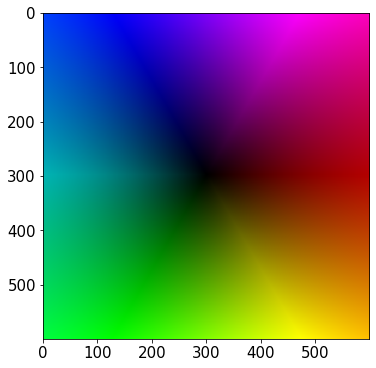

In [77]:
# Формирование изображения комплексной функции
# f(z)=z
z = getComplexDomain(nMax, nScale) # Область определения
f = z; # Формирование значений

# Формирование изображения HSV
hsv1 = np.zeros(shape=(2*nMax, 2*nMax, 3))

hsv1[:,:,0] = wrapTo2Pi(np.angle(f))/(2*np.pi) # Тон
hsv1[:,:,1] = 1 # Насыщенность
hsv1[:,:,2] = np.divide(np.abs(f), np.max(np.abs(f), axis=0)) # Яркость

rgb1 = clr.hsv_to_rgb(hsv1) # Преобразование в формат RGB
plt.imshow(rgb1); # Визуализация

### Графическое изображение функции f(z)=z*exp(z)

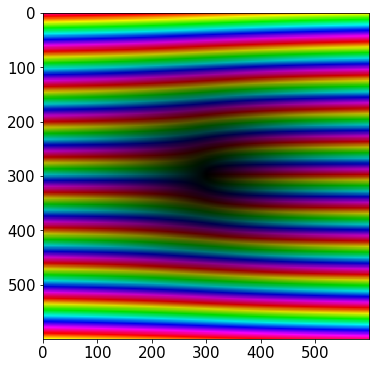

In [78]:
# Формирование изображения комплексной функции
# f(z)=z*exp(z)
f = np.multiply(z, np.exp(z)) # Формирование значений
# Формирование изображения HSV
hsv2 = np.zeros(shape=(2*nMax, 2*nMax, 3))
hsv2[:,:,0] = wrapTo2Pi(np.angle(f))/(2*np.pi) # Тон
hsv2[:,:,1] = 1 # Насыщенность
hsv2[:,:,2] = np.divide(np.abs(f), np.max(np.abs(f), axis=0)) # Яркость
rgb2 = clr.hsv_to_rgb(hsv2) # Преобразование в формат RGB
plt.imshow(rgb2) # Визуализация

### Графическое изображение функции f(z)=(z^2-i)/(z^2+i)

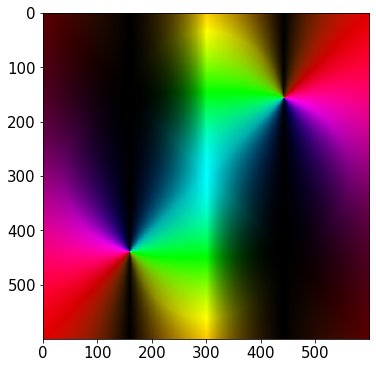

In [79]:
# Формирование изображения комплексной функции
# f(z)=(z^2-i)/(z^2+i)
nScale = 0.005 #nScale*0.05 # Изменение масштаба
z = getComplexDomain(nMax, nScale) # Область определения
f = np.divide(z**2-1j, z**2+1j) # Формирование значений
# Формирование изображения HSV
hsv3 = np.zeros(shape=(2*nMax, 2*nMax, 3))
hsv3[:,:,0] = wrapTo2Pi(np.angle(f))/(2*np.pi) # Тон
hsv3[:,:,1] = 1 # Насыщенность
hsv3[:,:,2] = np.divide(np.abs(f), np.max(np.abs(f), axis=0)) # Яркость
rgb3 = clr.hsv_to_rgb(hsv3) # Преобразование в формат RGB
plt.imshow(rgb3) # Визуализация

## Формировние изображений

### Добавление нормального шума

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


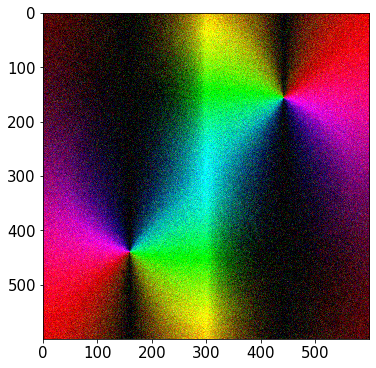

In [80]:
rgbn = awgn(0, 0.1, rgb3) # Шум 10 дБ
plt.imshow(rgbn) # Визуализация

### Объединение изображений и сохранение в файл

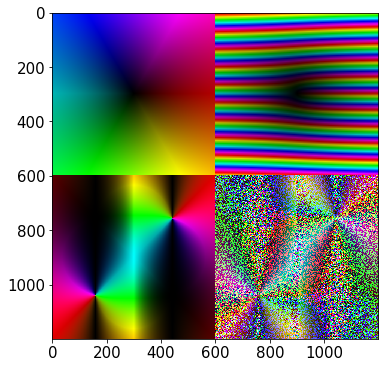

In [81]:
# Объединение массивов изображений
rgb0 = np.concatenate([np.concatenate([rgb1, rgb2], axis=1), np.concatenate([rgb3, rgbn], axis=1)], axis=0)
plt.imshow((rgb0 * 255).astype(np.uint8)) # Визуализация

In [82]:
# Сохранение в формате JPG
plt.imsave('picture.jpg', (rgb0 * 255).astype(np.uint8))

In [83]:
S, fd = wav.read("gamma (1).wav") # Мелодия из файла

## Формирование видеоизображения

In [118]:
# Формирование видеоизображения
sPPF = S/frameRate # Количество отсчетов звука на кадр
# Открытие видеофайла
new_gamma = []
sig_avg_watts = np.mean(rgb3)
sig_avg_db = 10 * np.log10(sig_avg_watts)
out = cv2.VideoWriter("video.mp4", cv2.VideoWriter_fourcc(*'MP42'), float(frameRate), (1200, 1200))
for i in range(0,fCount):
    nNoiseLevel = round(60*i/fCount-20) # уровень шума в кадре, Дб
    sNoiseLevel = 'SNR {Noise} dB'.format(Noise = str(nNoiseLevel)) # надпись SNR
    noise_avg_db = sig_avg_db - nNoiseLevel
    noise_avg_watts = 10 ** (noise_avg_db / 6)
    rgbn = awgn(0, np.sqrt(noise_avg_watts), rgb3) # добавление шума
    rgb0 = np.concatenate([np.concatenate([rgb1, rgb2], axis=1), np.concatenate([rgb3, rgbn], axis=1)], axis=0)
    rgb0 = (rgb0 * 255).astype(np.uint8)
    cv2.putText(rgb0, sNoiseLevel, (820,880),  cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255) )
    if i>startText0*frameRate:
        cv2.putText(rgb0, 'An image is...', (250,640), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255) )
    if i>startText1*frameRate:
         cv2.putText(rgb0, '... a singal also', (610,590), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255) )
    startIndex = (i-1)*sPPF+1
    endIndex = i*sPPF
    out.write(rgb0)
cv2.destroyAllWindows()
out.release()


In [119]:
from moviepy.editor import *
videoclip = VideoFileClip("video.mp4")
audioclip = AudioFileClip("gamma.wav")

new_audioclip = CompositeAudioClip([audioclip])
videoclip.audio = new_audioclip
videoclip.write_videofile("new_filename.mp4")

[MoviePy] >>>> Building video new_filename.mp4
[MoviePy] Writing audio in new_filenameTEMP_MPY_wvf_snd.mp3


100%|███████████████████████████████████████████████████████████████████████████████| 331/331 [00:00<00:00, 382.42it/s]


[MoviePy] Done.
[MoviePy] Writing video new_filename.mp4


100%|███████████████████████████████████████████████████████████████████████████████▊| 375/376 [00:47<00:00, 14.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: new_filename.mp4 

